## Perceptron

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Perceptron:

    def predict(self, X):
        return (np.dot(self.add_bias(X), self.weights) >= 0) * 1

    def fit(self, X, y, itr=1000, lr=0.0001):
        X = self.add_bias(X)
        self.weights = np.zeros(X.shape[1])
        for _ in range(itr):
            self.weights += lr * np.dot((y - self.predict(X[:,1:])), X)

    def add_bias(self,X):
        return np.insert(X, 0, np.ones(X.shape[0]), axis=1)

In [ ]:
def plot_hyperplane(X, y, weights, bias):
    """
    Plots the dataset and the estimated decision hyperplane
    """
    slope = - weights[0]/weights[1]
    intercept = - bias/weights[1]
    x_hyperplane = np.linspace(-10,10,10)
    y_hyperplane = slope * x_hyperplane + intercept
    fig = plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.plot(x_hyperplane, y_hyperplane, '-')
    plt.title("Dataset and fitted decision hyperplane")
    plt.xlabel("First feature")
    plt.ylabel("Second feature")
    plt.show()

In [ ]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
X, y = load_digits(return_X_y=True)
clf = Perceptron()
clf.fit(X, (y==9)*1)
pre = clf.predict(X)
accuracy_score((y==9)*1, pre) # Predicting 9

0.9905397885364496

In [ ]:

# This will handle any type of binary target int or categorical
class Perceptron2:

    def predict(self, X):
        X = self.add_bias(X)
        convert_to_class = lambda c: self.classes[1] if c >= 0 else self.classes[0]
        return np.vectorize(convert_to_class)(X.dot(self.weights))

    def fit(self, X, y, epochs=1000, lr=0.001):
        self.classes = np.unique(y)
        X = self.add_bias(X)
        y = (y == self.classes[1]) * 1
        self.weights = np.zeros(X.shape[1])
        for _ in range(epochs):
            self.weights += lr * np.dot((y - self.predict(X[:,1:])), X)

    def add_bias(self,X):
        return np.insert(X, 0, np.ones(X.shape[0]), axis=1)

In [ ]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
X, y = load_digits(return_X_y=True)
clf = Perceptron2()
clf.fit(X, (y==9)*1)
pre = clf.predict(X)
accuracy_score((y==9)*1, pre) # Predicting 9

0.9922092376182526

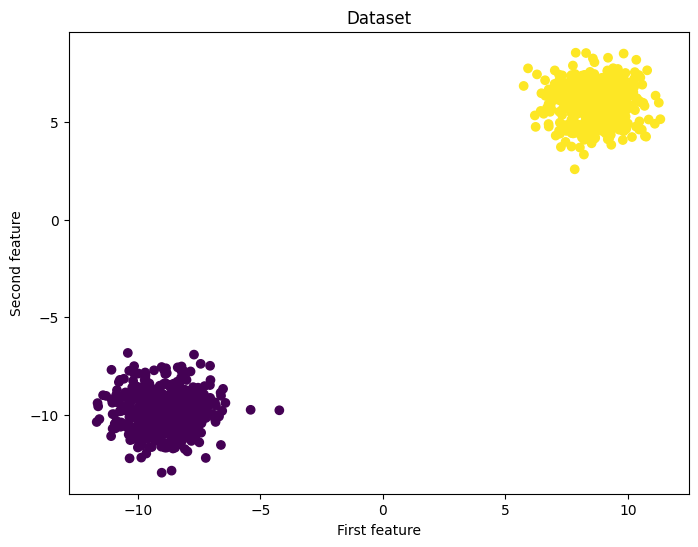

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=1000, centers=2)
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
p = Perceptron()
p.fit(X_train, y_train)
y_p_train = p.predict(X_train)
y_p_test = p.predict(X_test)
print("training accuracy: {} %".format(100 - np.mean(np.abs(y_p_train - y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_p_test - y_test)) * 100))

training accuracy: 100.0 %
test accuracy: 100.0 %


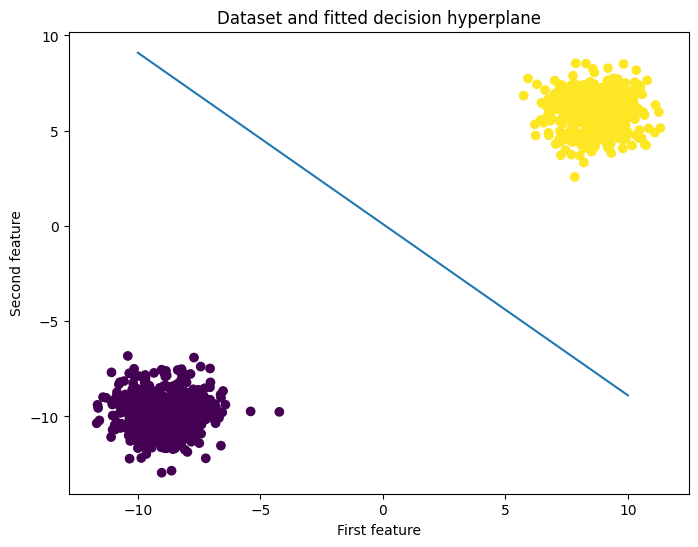

In [ ]:
plot_hyperplane(X, y, p.weights[1:], p.weights[0])

------------------------------------------------------------------------------------------

## Backpropagation

In [ ]:
# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['output'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# test backpropagation of error
network = [[{'output': 0.7105668883115941, 'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}],
		[{'output': 0.6213859615555266, 'weights': [0.2550690257394217, 0.49543508709194095]}, {'output': 0.6573693455986976, 'weights': [0.4494910647887381, 0.651592972722763]}]]
expected = [0, 1]
backward_propagate_error(network, expected)
for layer in network:
	print(layer)

[{'output': 0.7105668883115941, 'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614], 'delta': -0.0005348048046610517}]
[{'output': 0.6213859615555266, 'weights': [0.2550690257394217, 0.49543508709194095], 'delta': -0.14619064683582808}, {'output': 0.6573693455986976, 'weights': [0.4494910647887381, 0.651592972722763], 'delta': 0.0771723774346327}]


In [ ]:
import sys
import json
from pathlib import Path
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

# global static variables
dtype_mult = 255.0 # unit8
num_classes = 10
X_shape = (-1, 32, 32, 3)
epoch = 200
batch_size = 128

def get_dataset():
    sys.stdout.write('Loading Dataset\n')
    sys.stdout.flush()

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    return X_train, y_train, X_test, y_test

def get_preprocessed_dataset():
    X_train, y_train, X_test, y_test = get_dataset()

    sys.stdout.write('Preprocessing Dataset\n\n')
    sys.stdout.flush()

    X_train = X_train.astype('float32') / dtype_mult
    X_test = X_test.astype('float32') / dtype_mult
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_test, y_test

def generate_optimizer():
    return keras.optimizers.Adam()

def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer=generate_optimizer(),
                  metrics=['accuracy'])

def generate_model():
    # check if model exists if exists then load model from saved state
    if Path('./models/convnet_model.json').is_file():
        sys.stdout.write('Loading existing model\n\n')
        sys.stdout.flush()

        with open('./models/convnet_model.json') as file:
            model = keras.models.model_from_json(json.load(file))
            file.close()

        # likewise for model weight, if exists load from saved state
        if Path('./models/convnet_weights.h5').is_file():
            model.load_weights('./models/convnet_weights.h5')

        compile_model(model)

        return model

    sys.stdout.write('Loading new model\n\n')
    sys.stdout.flush()

    model = Sequential()

    # Conv1 32 32 (3) => 30 30 (32)
    model.add(Conv2D(32, (3, 3), input_shape=X_shape[1:]))
    model.add(Activation('relu'))
    # Conv2 30 30 (32) => 28 28 (32)
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    # Pool1 28 28 (32) => 14 14 (32)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Conv3 14 14 (32) => 12 12 (64)
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    # Conv4 12 12 (64) => 6 6 (64)
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    # Pool2 6 6 (64) => 3 3 (64)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # FC layers 3 3 (64) => 576
    model.add(Flatten())
    # Dense1 576 => 256
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    # Dense2 256 => 10
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # compile has to be done impurely
    compile_model(model)

    with open('./models/convnet_model.json', 'w') as outfile:
        json.dump(model.to_json(), outfile)
        outfile.close()

    return model

def train(model, X_train, y_train, X_test, y_test):
    sys.stdout.write('Training model\n\n')
    sys.stdout.flush()

    # train each iteration individually to back up current state
    # safety measure against potential crashes
    epoch_count = 0
    while epoch_count < epoch:
        epoch_count += 1
        sys.stdout.write('Epoch count: ' + str(epoch_count) + '\n')
        sys.stdout.flush()
        model.fit(X_train, y_train, batch_size=batch_size,
                  nb_epoch=1, validation_data=(X_test, y_test))
        sys.stdout.write('Epoch {} done, saving model to file\n\n'.format(epoch_count))
        sys.stdout.flush()
        model.save_weights('./models/convnet_weights.h5')

    return model

def get_accuracy(pred, real):
    # reward algorithm
    result = pred.argmax(axis=1) == real.argmax(axis=1)
    return np.sum(result) / len(result)

def main():
    sys.stdout.write('Welcome to CIFAR-10 Hello world of CONVNET!\n\n')
    sys.stdout.flush()
    X_train, y_train, X_test, y_test = get_preprocessed_dataset()
    model = generate_model()
    model = train(model, X_train, y_train, X_test, y_test)


if __name__ == "__main__":
    # execute only if run as a script
    main()

Welcome to CIFAR-10 Hello world of CONVNET!

Loading Dataset
Preprocessing Dataset

Loading new model



ModuleNotFoundError: ignored

## Convolutional Neural Network (CNN)

In [ ]:
!pip install mnist

In [ ]:
!pip install conv

  Preparing metadata (setup.py) ... done
  Created wheel for conv: filename=conv-0.2-py3-none-any.whl size=5260 sha256=0b4977848fbd73c3bb340c4891504674b3e0b5bc559b81580bada4605f35f54f
  Stored in directory: /root/.cache/pip/wheels/ac/f7/76/ead54aa083e2eb7765730f5fc529371944ddfeaa29f0ae5ec8
Successfully built conv


In [ ]:
import numpy as np

'''
Note: In this implementation, we assume the input is a 2d numpy array for simplicity, because that's
how our MNIST images are stored. This works for us because we use it as the first layer in our
network, but most CNNs have many more Conv layers. If we were building a bigger network that needed
to use Conv3x3 multiple times, we'd have to make the input be a 3d numpy array.
'''

class Conv3x3:
  # A Convolution layer using 3x3 filters.

  def __init__(self, num_filters):
    self.num_filters = num_filters

    # filters is a 3d array with dimensions (num_filters, 3, 3)
    # We divide by 9 to reduce the variance of our initial values
    self.filters = np.random.randn(num_filters, 3, 3) / 9

  def iterate_regions(self, image):
    '''
    Generates all possible 3x3 image regions using valid padding.
    - image is a 2d numpy array.
    '''
    h, w = image.shape

    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the conv layer using the given input.
    Returns a 3d numpy array with dimensions (h, w, num_filters).
    - input is a 2d numpy array
    '''
    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
    # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
    # other layer in our CNN.
    return None

------------------------------------------------------------------------------------------------------------------